# Contrarian trading strategy

## Background:
A contrarian trading strategy involves generating value by taking positions that are contrary to prevailing market sentiments. In other words, contrarian investors typically buy assets during bear markets when the sentiment is negative and sell assets during bull markets when the sentiment is positive. The principle behind this strategy is that historically, above-average market returns have often followed periods of low optimism, while below-average market returns have often followed periods of high optimism. Therefore, by going against the prevailing sentiment, contrarian investors aim to profit from market movements that are driven by a shift in sentiment from extreme optimism to pessimism, and vice versa.

The goal is to develop a trading strategy that forecasts movements in the S&P 500 by utilizing a metric derived from investor sentiment. The performance of this strategy will be evaluated based on its ability to predict the movement of the S&P 500.

## Data Description:
The data is from AAII's Investor Sentiment Survey. This survey provides insights into the percentage of investors who are bullish, bearish, or neutral on the stock market and is widely considered as a contrarian indicator for the market.

- The data we are using for sentiment analysis is available on a weekly basis over a 35-year period from 1987 to 2023, and is stored in the "bull_bear_spread.xlsx" file. 
- The "Close" column of this file represents the difference between the percentage of respondents who reported feeling bullish and those who reported feeling bearish, with low values indicating more pessimistic investor sentiment.
- Finally, I have also obtained the S&P 500 price data from Yahoo Finance, which I have used to evaluate the performance of my trading strategy.

In [2]:
#importing libiaries
import os
import json
import matplotlib.pyplot as plt
import time
import requests
import datetime
import dateutil
import pandas as pd
import time
import numpy as np
from dateutil.relativedelta import relativedelta
import yfinance as yf
import pandas as pd
from scipy.stats import zscore

In [4]:
df = pd.read_excel('/Users/Dhriti/Desktop/Bull_Bear_Spread.xlsx', parse_dates = True)
df

,Date,Close
0,1987-07-24 00:00:00,0.22
1,1987-07-31 00:00:00,0.00
2,1987-08-07 00:00:00,0.27
3,1987-08-14 00:00:00,0.25
4,1987-08-21 00:00:00,0.60
...,...,...
2050,Count '18,52.00
2051,Count '19,52.00
2052,Count '20,53.00
2053,Count '21,51.00


In [485]:
date_index = [i for i in df.index if type(df['Date'][i]) == datetime.datetime]

In [486]:
df = df.iloc[:date_index[-1]+1,:]

In [488]:
#importing sp500 data
import yfinance as yf
sp500 = yf.download("^GSPC")[["Adj Close"]]
sp500

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
1927-12-30 00:00:00-05:00,17.660000
1928-01-03 00:00:00-05:00,17.760000
1928-01-04 00:00:00-05:00,17.719999
1928-01-05 00:00:00-05:00,17.549999
1928-01-06 00:00:00-05:00,17.660000
...,...
2023-03-13 00:00:00-04:00,3855.760010
2023-03-14 00:00:00-04:00,3919.290039
2023-03-15 00:00:00-04:00,3891.929932


In [522]:
df.set_index('Date', inplace = True)

In [490]:
#merging sp500 data with out df data frame
data = pd.merge_asof(df, sp500,left_index = True, right_index = True)

#Calculating percentage change in Adj Close price
data["Returns"] = np.log(data["Adj Close"]).diff()
data.dropna(inplace = True)

In [491]:
data

,Close,Adj Close,Returns
Date,,,
1987-07-31,0.000000,318.049988,0.032726
1987-08-07,0.270000,322.089996,0.012622
1987-08-14,0.250000,334.649994,0.038254
1987-08-21,0.600000,334.839996,0.000568
1987-08-28,0.220000,331.380005,-0.010387
...,...,...,...
2023-01-26,-0.083094,4016.219971,0.021992
2023-02-02,-0.046512,4119.209961,0.025320
2023-02-09,0.125000,4117.859863,-0.000328


### Description of strategy
This is a trading strategy that uses z-score to estimate if an asset is overvalued or undervalued relative to its historic average.

1. I have calculated mean and standard deviation of the asset for the previous years to generate signals

In [492]:
stats = data.groupby(data.index.year)['Close'].agg(['mean', 'std'])
def zscore_yearly(row):
    year = row.name.year
    prev_year = year - 1
    if year == data.index.year.min():
        row['z_score'] = 0
    else:
        row['z_score'] = (row['Close'] - stats.loc[prev_year, 'mean']) / stats.loc[prev_year, 'std']
    return row

data = data.groupby(data.index).apply(zscore_yearly)
data

,Close,Adj Close,Returns,z_score
Date,,,,
1987-07-31,0.000000,318.049988,0.032726,0.000000
1987-08-07,0.270000,322.089996,0.012622,0.000000
1987-08-14,0.250000,334.649994,0.038254,0.000000
1987-08-21,0.600000,334.839996,0.000568,0.000000
1987-08-28,0.220000,331.380005,-0.010387,0.000000
...,...,...,...,...
2023-01-26,-0.083094,4016.219971,0.021992,1.103073
2023-02-02,-0.046512,4119.209961,0.025320,1.409814
2023-02-09,0.125000,4117.859863,-0.000328,2.847947


### Strategy 
- if z-score is > 2 then go short as we expect the market to be bullish 
- if z-score is < 2 then go long as we expect the market to be bearish

In [493]:
def get_position(score):
    if score > 2:
        return -1
    elif score < -2:
        return 1
    else:
        return 0

data['strategy'] = data['z_score'].apply(get_position)
data

,Close,Adj Close,Returns,z_score,strategy
Date,,,,,
1987-07-31,0.000000,318.049988,0.032726,0.000000,0
1987-08-07,0.270000,322.089996,0.012622,0.000000,0
1987-08-14,0.250000,334.649994,0.038254,0.000000,0
1987-08-21,0.600000,334.839996,0.000568,0.000000,0
1987-08-28,0.220000,331.380005,-0.010387,0.000000,0
...,...,...,...,...,...
2023-01-26,-0.083094,4016.219971,0.021992,1.103073,0
2023-02-02,-0.046512,4119.209961,0.025320,1.409814,0
2023-02-09,0.125000,4117.859863,-0.000328,2.847947,-1


In [520]:
data["cumulative_returns"] = np.exp((data['strategy'].shift()*data.Returns).cumsum())-1


In [498]:
data["strat_returns"] = data['strategy'].shift()*data.Returns
data

,Close,Adj Close,Returns,z_score,strategy,cumulative_returns,strat_returns
Date,,,,,,,
1987-07-31,0.000000,318.049988,0.032726,0.000000,0,NaN,NaN
1987-08-07,0.270000,322.089996,0.012622,0.000000,0,0.000000,0.000000
1987-08-14,0.250000,334.649994,0.038254,0.000000,0,0.000000,0.000000
1987-08-21,0.600000,334.839996,0.000568,0.000000,0,0.000000,0.000000
1987-08-28,0.220000,331.380005,-0.010387,0.000000,0,0.000000,-0.000000
...,...,...,...,...,...,...,...
2023-01-26,-0.083094,4016.219971,0.021992,1.103073,0,0.256681,0.000000
2023-02-02,-0.046512,4119.209961,0.025320,1.409814,0,0.256681,0.000000
2023-02-09,0.125000,4117.859863,-0.000328,2.847947,-1,0.256681,-0.000000


In [5]:
### testing our strategy and estimating the success of my strategy 

### Total rate of return

In [510]:
total_return = data["cumulative_returns"].iloc[-1] 
total_return
# Print the total return
print("Total Return %.2f%%"% total_return)

Total Return 0.30%


### Annualised return

In [503]:
# Assuming the investment period is 22 years t = len(val_df)/52
t = len(data)/52
P = 1000
A = (1+0.296610)*P
annual = ((A/P)**(1/t)-1)*100

# Print the annualized return
print("Annualized Return %.2f%%"% annual)

Annualized Return 0.73%


### Rate of return only over the days we hold a position

In [505]:
P = 1000
A = (1+ 0.296610)*P
T = len(data[data["strategy"]!= 0])/52
Rate_of_return = ((A/P)**(1/T)-1)*100 
Rate_of_return

6.915343352038716

### Sharpe ratio

In [511]:
rate = pd.read_csv('/Users/Dhriti/Desktop/1-year-treasury-rate-yield-chart.csv', index_col = 0, parse_dates = True)

In [508]:
cols = [i for i in data.columns]
cols.append('risk_free')

In [512]:
ratio = pd.merge_asof(data, rate,left_index = True, right_index = True)
ratio

,Close,Adj Close,Returns,z_score,strategy,cumulative_returns,strat_returns,value
Date,,,,,,,,
1987-07-31,0.000000,318.049988,0.032726,0.000000,0,NaN,NaN,6.89
1987-08-07,0.270000,322.089996,0.012622,0.000000,0,0.000000,0.000000,6.97
1987-08-14,0.250000,334.649994,0.038254,0.000000,0,0.000000,0.000000,6.91
1987-08-21,0.600000,334.839996,0.000568,0.000000,0,0.000000,0.000000,7.04
1987-08-28,0.220000,331.380005,-0.010387,0.000000,0,0.000000,-0.000000,7.26
...,...,...,...,...,...,...,...,...
2023-01-26,-0.083094,4016.219971,0.021992,1.103073,0,0.256681,0.000000,NaN
2023-02-02,-0.046512,4119.209961,0.025320,1.409814,0,0.256681,0.000000,NaN
2023-02-09,0.125000,4117.859863,-0.000328,2.847947,-1,0.256681,-0.000000,NaN


In [513]:
returns = ratio[["strat_returns"]].copy().dropna()

In [514]:
returns["risk_free"] = (ratio[[' value']].dropna()/100+1)**(1/52)-1
returns.columns

Index(['strat_returns', 'risk_free'], dtype='object')

In [515]:
returns["excess_return"] = returns['strat_returns'] - returns['risk_free']
returns

,strat_returns,risk_free,excess_return
Date,,,
1987-08-07,0.000000,0.001297,-0.001297
1987-08-14,0.000000,0.001286,-0.001286
1987-08-21,0.000000,0.001309,-0.001309
1987-08-28,-0.000000,0.001349,-0.001349
1987-09-04,-0.000000,0.001415,-0.001415
...,...,...,...
2023-01-26,0.000000,NaN,NaN
2023-02-02,0.000000,NaN,NaN
2023-02-09,-0.000000,NaN,NaN


In [516]:
sharpe = (returns["excess_return"].mean())/(returns["excess_return"].std())
sharpe
## low sharpe ratio

-0.05020024410205647

Our sharpe ratio is negative indicating that out risk free assets give a higher return as compared to our strategy. This result indicates that perhaps our strategy may not be very good and a risk averse investor should be better off investing in risk free assets. 


### Gini Coefficient

In [517]:
def GINI_COEF(returns):
    # get the number of periods -> will allow us to calculate the areas
    periods = len(returns)
    
    # sort values and sum to calculate the lorenz curve
    LorenzCurve = np.cumsum(returns.sort_values( by = "strat_returns"))
    # start from 0
    LorenzCurve = pd.DataFrame({ 'strat_returns': [0]}).append(LorenzCurve)
    Line = LorenzCurve.copy()
    # Form the line that encompasses A and B
    Line["strat_returns"] = np.arange(0,1+1/periods, 1/periods)*max(LorenzCurve["strat_returns"])
    
    # calculate the area of A+B
    UpArea = 0
    for i in range(1,len(returns)):
        UpArea = UpArea + ((Line.iloc[i,:] - LorenzCurve.iloc[i,:] + Line.iloc[i-1,:] - LorenzCurve.iloc[i-1,:]) / 2)
    # calculate the area of A+B+C
    if min(LorenzCurve["strat_returns"]) < 0:
        AllArea = (np.abs(min(LorenzCurve["strat_returns"])) * periods) + ((max(LorenzCurve["strat_returns"]) * periods)/2)
    else:
        AllArea = ((max(LorenzCurve["strat_returns"]) * periods)/2)
    gini = UpArea / AllArea
    return (gini[0])

/var/folders/j8/qj6z29_s2qj2dwzv274nkt9h0000gp/T/ipykernel_5398/1310426132.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LorenzCurve = pd.DataFrame({ 'strat_returns': [0]}).append(LorenzCurve)


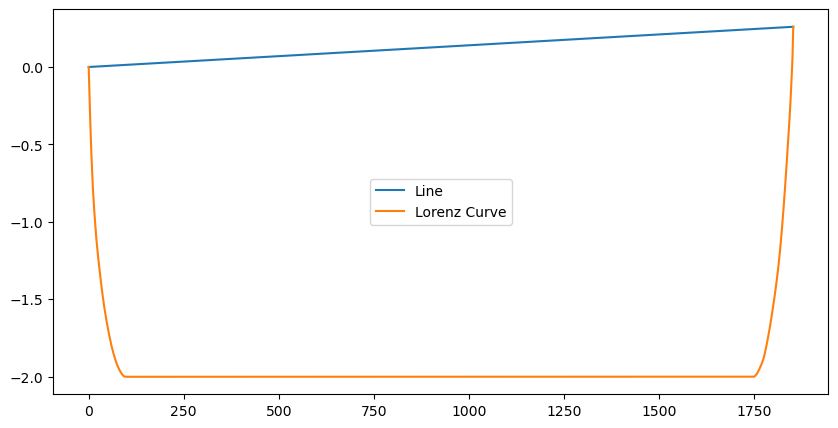

In [519]:
periods = len(returns)
LorenzCurve = np.cumsum(returns.sort_values( by = "strat_returns"))
# start from 0
LorenzCurve = pd.DataFrame({ 'strat_returns': [0]}).append(LorenzCurve)
Line = LorenzCurve.copy()
Line["strat_returns"] = np.arange(0,1+1/periods, 1/periods)*max(LorenzCurve["strat_returns"])
plt.figure(figsize = (10, 5))
plt.plot(Line["strat_returns"].values)
plt.plot(LorenzCurve["strat_returns"].values)
plt.legend(["Line", "Lorenz Curve"])

In [518]:
GINI_COEF(returns)

/var/folders/j8/qj6z29_s2qj2dwzv274nkt9h0000gp/T/ipykernel_5398/3340652914.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LorenzCurve = pd.DataFrame({ 'strat_returns': [0]}).append(LorenzCurve)


0.9702704946764391

Large gini coefficient means that the returns are not spread over a period of time. We can see that there is a large distance between the equality line and the lorenz curve. If the investor is risk averse such a strategy would not work well for such an investor. 